## Part A. Preliminaries

## 3. Acquiring dataset

In [1]:
import pandas as pd #data loader library
import matplotlib.pyplot as plt #graph visualization library
import numpy as np
#iris dataset을 얻고 class별로 분리해놓는다.
df = pd.read_csv('./iris/iris.data', names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
se=df[df['class'] =='Iris-setosa']
ve=df[df['class']=='Iris-versicolor']
vi=df[df['class']=='Iris-virginica']

## Part B. Iris classification using text data

## 4.

In [2]:
#iris dataset을 섞는다.
import random

idx = list(range(0,150))
random.shuffle(idx)

In [3]:
#gaussian distribution을 정의한다.
def gaussian(x, mean, sigma):
    variance = sigma**2
    return (1/np.sqrt(2*np.pi*variance)) * np.exp(-((x-mean)**2)/(2*variance))

In [4]:
#5번을 위해 5-fold cross validation할 때 계산한 gaussian distribution을 저장한다.
se_sl_gaussian = []
se_sw_gaussian = []
se_pl_gaussian = []
se_pw_gaussian = []
ve_sl_gaussian = []
ve_sw_gaussian = []
ve_pl_gaussian = []
ve_pw_gaussian = []
vi_sl_gaussian = []
vi_sw_gaussian = []
vi_pl_gaussian = []
vi_pw_gaussian = []

### -Sepal Length feature를 사용한 classifier

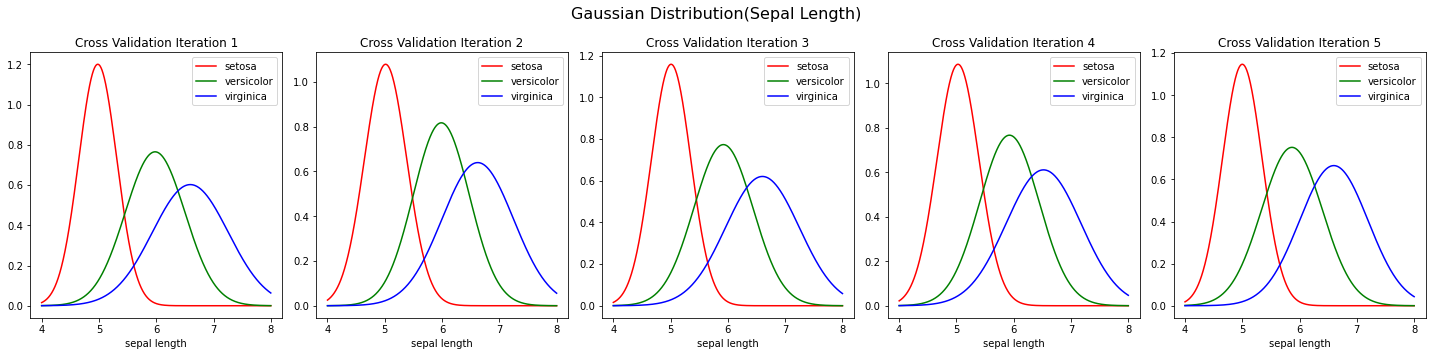

precision : 0.7393445443445443
recall : 0.7307094757094758


In [5]:
precision = []
recall = []
fig, axes = plt.subplots(1,5,figsize=(20,5))
fig.suptitle("Gaussian Distribution(Sepal Length)", fontsize=16)
#5-fold cross validation
for i in range(5):
    
    se_tp_n = 0 #setosa true positive
    ve_tp_n = 0 #versicolor true positive
    vi_tp_n = 0 #virginica true positive
    
    se_p_n = 0 #setosa positive
    ve_p_n = 0 #versicolor positive
    vi_p_n = 0 #virginica positive
    
    #(i+1)번째 fold는 evaluation에 사용하고 (i+1)번째 fold를 제외한 4개의 fold를 training에 사용
    idx_eval = idx[i*30: (i+1)*30]
    idx_data = idx[:i*30]+idx[(i+1)*30:]

    data = df.loc[idx_data]
    eval_data = df.loc[idx_eval]
    eval_class = eval_data['class']
    eval_prediction = []

    se_data=data[data['class'] =='Iris-setosa']
    ve_data=data[data['class']=='Iris-versicolor']
    vi_data=data[data['class']=='Iris-virginica']
    se_size = len(se_data)
    ve_size = len(ve_data)
    vi_size = len(vi_data)
    
    #prior는 전체 120개 instance에 있는 각 class의 instance의 비율로 설정한다.
    se_prior = se_size/120
    ve_prior = ve_size/120
    vi_prior = vi_size/120
    
    #sepal length gaussian distribution
    se_mean = se_data['sepal length'].mean()
    se_std = se_data['sepal length'].std()
    
    ve_mean = ve_data['sepal length'].mean()
    ve_std = ve_data['sepal length'].std()
    
    vi_mean = vi_data['sepal length'].mean()
    vi_std = vi_data['sepal length'].std()
    
    #sepal length likelihood를 gaussian distribution으로 모델링한다.
    se_gaussian = np.zeros(41)
    ve_gaussian = np.zeros(41)
    vi_gaussian = np.zeros(41)

    sl = 3.9
    for j in range(41):
        sl += 0.1
        sl = round(sl,1)
        index = int(round((sl-4.0)/0.1,1))
        se_gaussian[index] = gaussian(sl, se_mean, se_std)
        ve_gaussian[index] = gaussian(sl, ve_mean, ve_std)
        vi_gaussian[index] = gaussian(sl, vi_mean, vi_std)
    
    #5번을 위해 5-fold cross validation할 때 계산한 gaussian distribution을 저장한다.
    se_sl_gaussian.append(se_gaussian)
    ve_sl_gaussian.append(ve_gaussian)
    vi_sl_gaussian.append(vi_gaussian)
    
    #parameter를 통해 구한 gaussian distribution을 그린다.
    x = np.linspace(4,8,1000)
    axes[i].plot(x, gaussian(x, se_mean, se_std), label='setosa', color='red')
    axes[i].plot(x, gaussian(x, ve_mean, ve_std), label='versicolor', color='green')
    axes[i].plot(x, gaussian(x, vi_mean, vi_std), label='virginica', color='blue')
    axes[i].set_xlabel("sepal length")
    axes[i].set_title("Cross Validation Iteration " + str(i+1))
    axes[i].legend()
    
    #sepal length posterior probability
    se_posterior = np.zeros(41)
    ve_posterior = np.zeros(41)
    vi_posterior = np.zeros(41)
    
    for j in range(41) :
        evidence = se_gaussian[j] * se_prior + ve_gaussian[j] * ve_prior + vi_gaussian[j] * vi_prior
        if evidence == 0 :
            se_posterior[j] = 0
            ve_posterior[j] = 0
            vi_posterior[j] = 0
            continue
            
        se_posterior[j] = se_gaussian[j] * se_prior / evidence
        ve_posterior[j] = ve_gaussian[j] * ve_prior / evidence
        vi_posterior[j] = vi_gaussian[j] * vi_prior / evidence
  
    #(i+1)번째 fold에 대해 evaluation한다.
    for j in range(30):
        d = eval_data.iloc[j]
        sl = float(d['sepal length'])
        sl_idx = int(round((sl-4.0)/0.1,1))
        
        #가장 posterior가 높은 class로 분류한다.
        #모든 data에 대해 p(error|x)가 최소화되도록 선택했기 때문에 총 cost인 p(error)도 최소화된다.
        max_prob = max(max(se_posterior[sl_idx],ve_posterior[sl_idx]),vi_posterior[sl_idx])
        if max_prob == se_posterior[sl_idx] : 
            eval_prediction.append('Iris-setosa')
            se_p_n += 1
            if d['class'] == 'Iris-setosa' : se_tp_n += 1
        elif max_prob == ve_posterior[sl_idx] : 
            eval_prediction.append('Iris-versicolor')
            ve_p_n += 1
            if d['class'] == 'Iris-versicolor' : ve_tp_n += 1
        elif max_prob == vi_posterior[sl_idx] : 
            eval_prediction.append('Iris-virginica')
            vi_p_n += 1
            if d['class'] == 'Iris-virginica' : vi_tp_n += 1
    
    if se_p_n == 0 :
        se_precision = 0
        se_recall = 0
    else : 
        se_precision = se_tp_n / se_p_n
        se_recall = se_tp_n / (50-se_size)
    
    if ve_p_n == 0 :
        ve_precision = 0
        ve_recall = 0
    else : 
        ve_precision = ve_tp_n / ve_p_n
        ve_recall = ve_tp_n / (50-ve_size)
        
    if vi_p_n == 0 :
        vi_precision = 0
        vi_recall = 0
    else : 
        vi_precision = vi_tp_n / vi_p_n
        vi_recall = vi_tp_n / (50-vi_size)

    precision.append((se_precision+ve_precision+vi_precision)/3)
    recall.append((se_recall+ve_recall+vi_recall)/3)

plt.tight_layout()
plt.show()
mean_precision = sum(precision)/5
mean_recall = sum(recall)/5

print("precision : " + str(mean_precision))
print("recall : " + str(mean_recall))


### - Sepal Width feature를 사용한 classifier

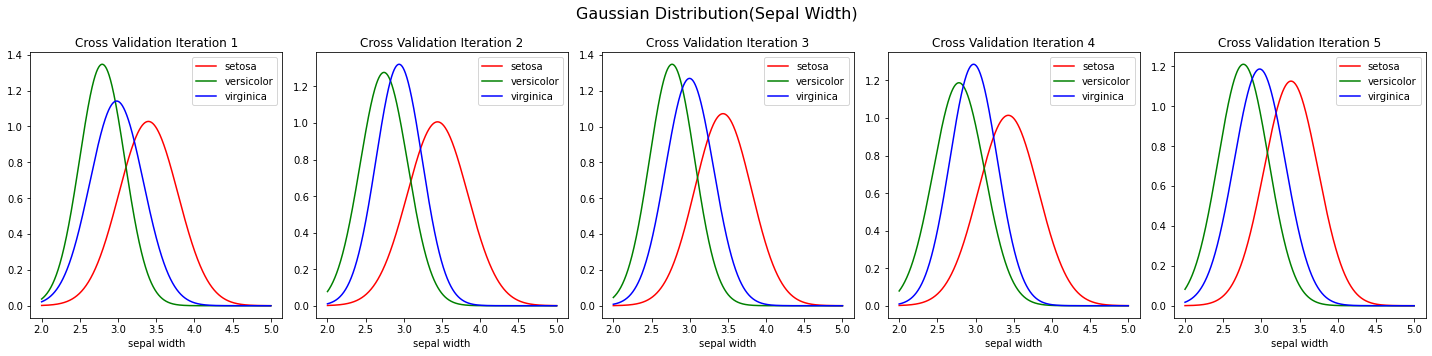

precision : 0.5808870564133721
recall : 0.5676551226551226


In [6]:
import numpy as np
precision = []
recall = []
fig, axes = plt.subplots(1,5,figsize=(20,5))
fig.suptitle("Gaussian Distribution(Sepal Width)", fontsize=16)
#5-fold cross validation
for i in range(5):
    
    se_tp_n = 0 #setosa true positive
    ve_tp_n = 0 #versicolor true positive
    vi_tp_n = 0 #virginica true positive
    
    se_p_n = 0 #setosa positive
    ve_p_n = 0 #versicolor positive
    vi_p_n = 0 #virginica positive
    
    #(i+1)번째 fold는 evaluation에 사용하고 ith fold를 제외한 4개의 fold를 training에 사용
    idx_eval = idx[i*30: (i+1)*30]
    idx_data = idx[:i*30]+idx[(i+1)*30:]

    data = df.loc[idx_data]
    eval_data = df.loc[idx_eval]
    eval_class = eval_data['class']
    eval_prediction = []

    se_data=data[data['class'] =='Iris-setosa']
    ve_data=data[data['class']=='Iris-versicolor']
    vi_data=data[data['class']=='Iris-virginica']
    se_size = len(se_data)
    ve_size = len(ve_data)
    vi_size = len(vi_data)
    
    #prior
    se_prior = se_size/120
    ve_prior = ve_size/120
    vi_prior = vi_size/120
    
    #sepal width gaussian distribution
    se_mean = se_data['sepal width'].mean()
    se_std = se_data['sepal width'].std()
    
    ve_mean = ve_data['sepal width'].mean()
    ve_std = ve_data['sepal width'].std()
    
    vi_mean = vi_data['sepal width'].mean()
    vi_std = vi_data['sepal width'].std()
    
    #sepal width likelihood를 gaussian distribution으로 모델링한다.
    se_gaussian = np.zeros(31)
    ve_gaussian = np.zeros(31)
    vi_gaussian = np.zeros(31)

    sw = 1.9
    for j in range(31):
        sw += 0.1
        sw = round(sw,1)
        index = int(round((sw-2.0)/0.1,1))
        se_gaussian[index] = gaussian(sw, se_mean, se_std)
        ve_gaussian[index] = gaussian(sw, ve_mean, ve_std)
        vi_gaussian[index] = gaussian(sw, vi_mean, vi_std)
    
    se_sw_gaussian.append(se_gaussian)
    ve_sw_gaussian.append(ve_gaussian)
    vi_sw_gaussian.append(vi_gaussian)
        
    x = np.linspace(2,5,1000)
    axes[i].plot(x, gaussian(x, se_mean, se_std), label='setosa', color='red')
    axes[i].plot(x, gaussian(x, ve_mean, ve_std), label='versicolor', color='green')
    axes[i].plot(x, gaussian(x, vi_mean, vi_std), label='virginica', color='blue')
    axes[i].set_xlabel("sepal width")
    axes[i].set_title("Cross Validation Iteration " + str(i+1))
    axes[i].legend()
    
    #sepal width posterior probability
    se_posterior = np.zeros(31)
    ve_posterior = np.zeros(31)
    vi_posterior = np.zeros(31)
    
    for j in range(31) :
        evidence = se_gaussian[j] * se_prior + ve_gaussian[j] * ve_prior + vi_gaussian[j] * vi_prior
        if evidence == 0 :
            se_posterior[j] = 0
            ve_posterior[j] = 0
            vi_posterior[j] = 0
            continue
            
        se_posterior[j] = se_gaussian[j] * se_prior / evidence
        ve_posterior[j] = ve_gaussian[j] * ve_prior / evidence
        vi_posterior[j] = vi_gaussian[j] * vi_prior / evidence
  
    #(i+1)번째 fold에 대해 evaluation한다.
    for j in range(30):
        d = eval_data.iloc[j]
        sw = float(d['sepal width'])
        sw_idx = int(round((sw-2.0)/0.1,1))
        
        max_prob = max(max(se_posterior[sw_idx],ve_posterior[sw_idx]),vi_posterior[sw_idx])
        if max_prob == se_posterior[sw_idx] : 
            eval_prediction.append('Iris-setosa')
            se_p_n += 1
            if d['class'] == 'Iris-setosa' : se_tp_n += 1
        elif max_prob == ve_posterior[sw_idx] : 
            eval_prediction.append('Iris-versicolor')
            ve_p_n += 1
            if d['class'] == 'Iris-versicolor' : ve_tp_n += 1
        elif max_prob == vi_posterior[sw_idx] : 
            eval_prediction.append('Iris-virginica')
            vi_p_n += 1
            if d['class'] == 'Iris-virginica' : vi_tp_n += 1
    
    if se_p_n == 0 :
        se_precision = 0
        se_recall = 0
    else : 
        se_precision = se_tp_n / se_p_n
        se_recall = se_tp_n / (50-se_size)
    
    if ve_p_n == 0 :
        ve_precision = 0
        ve_recall = 0
    else : 
        ve_precision = ve_tp_n / ve_p_n
        ve_recall = ve_tp_n / (50-ve_size)
        
    if vi_p_n == 0 :
        vi_precision = 0
        vi_recall = 0
    else : 
        vi_precision = vi_tp_n / vi_p_n
        vi_recall = vi_tp_n / (50-vi_size)

    precision.append((se_precision+ve_precision+vi_precision)/3)
    recall.append((se_recall+ve_recall+vi_recall)/3)

plt.tight_layout()
plt.show()
mean_precision = sum(precision)/5
mean_recall = sum(recall)/5

print("precision : " + str(mean_precision))
print("recall : " + str(mean_recall))


### - Petal Length feature를 사용한 classifier

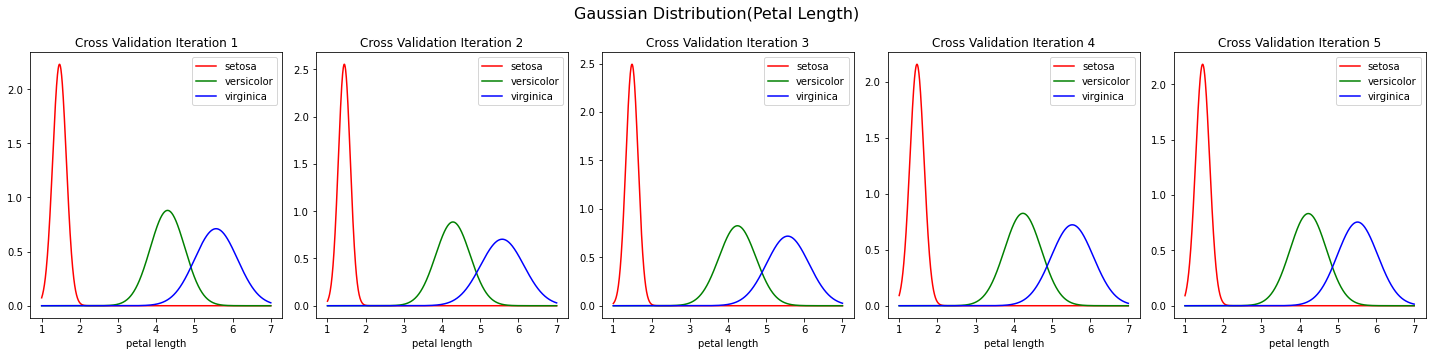

precision : 0.9561279461279462
recall : 0.9540909090909091


In [7]:
import numpy as np
precision = []
recall = []
fig, axes = plt.subplots(1,5,figsize=(20,5))
fig.suptitle("Gaussian Distribution(Petal Length)", fontsize=16)
#5-fold cross validation
for i in range(5):
    
    se_tp_n = 0 #setosa true positive
    ve_tp_n = 0 #versicolor true positive
    vi_tp_n = 0 #virginica true positive
    
    se_p_n = 0 #setosa positive
    ve_p_n = 0 #versicolor positive
    vi_p_n = 0 #virginica positive
    
    #(i+1)번째 fold는 evaluation에 사용하고 (i+1)번째 fold를 제외한 4개의 fold를 training에 사용
    idx_eval = idx[i*30: (i+1)*30]
    idx_data = idx[:i*30]+idx[(i+1)*30:]

    data = df.loc[idx_data]
    eval_data = df.loc[idx_eval]
    eval_class = eval_data['class']
    eval_prediction = []

    se_data=data[data['class'] =='Iris-setosa']
    ve_data=data[data['class']=='Iris-versicolor']
    vi_data=data[data['class']=='Iris-virginica']
    se_size = len(se_data)
    ve_size = len(ve_data)
    vi_size = len(vi_data)
    
    #prior
    se_prior = se_size/120
    ve_prior = ve_size/120
    vi_prior = vi_size/120
    
    #petal length gaussian distribution
    se_mean = se_data['petal length'].mean()
    se_std = se_data['petal length'].std()
    
    ve_mean = ve_data['petal length'].mean()
    ve_std = ve_data['petal length'].std()
    
    vi_mean = vi_data['petal length'].mean()
    vi_std = vi_data['petal length'].std()
    
    #petal length likelihood를 gaussian distribution으로 모델링한다.
    se_gaussian = np.zeros(61)
    ve_gaussian = np.zeros(61)
    vi_gaussian = np.zeros(61)

    pl = 0.9
    for j in range(61):
        pl += 0.1
        pl = round(pl,1)
        index = int(round((pl-1.0)/0.1,1))
        se_gaussian[index] = gaussian(pl, se_mean, se_std)
        ve_gaussian[index] = gaussian(pl, ve_mean, ve_std)
        vi_gaussian[index] = gaussian(pl, vi_mean, vi_std)
    
    se_pl_gaussian.append(se_gaussian)
    ve_pl_gaussian.append(ve_gaussian)
    vi_pl_gaussian.append(vi_gaussian)
        
    x = np.linspace(1,7,1000)
    axes[i].plot(x, gaussian(x, se_mean, se_std), label='setosa', color='red')
    axes[i].plot(x, gaussian(x, ve_mean, ve_std), label='versicolor', color='green')
    axes[i].plot(x, gaussian(x, vi_mean, vi_std), label='virginica', color='blue')
    axes[i].set_xlabel("petal length")
    axes[i].set_title("Cross Validation Iteration " + str(i+1))
    axes[i].legend()
    
    #petal length posterior probability
    se_posterior = np.zeros(61)
    ve_posterior = np.zeros(61)
    vi_posterior = np.zeros(61)
    
    for j in range(61) :
        evidence = se_gaussian[j] * se_prior + ve_gaussian[j] * ve_prior + vi_gaussian[j] * vi_prior
        if evidence == 0 :
            se_posterior[j] = 0
            ve_posterior[j] = 0
            vi_posterior[j] = 0
            continue
            
        se_posterior[j] = se_gaussian[j] * se_prior / evidence
        ve_posterior[j] = ve_gaussian[j] * ve_prior / evidence
        vi_posterior[j] = vi_gaussian[j] * vi_prior / evidence
  
    #(i+1)번째 fold에 대해 evaluation한다.
    for j in range(30):
        d = eval_data.iloc[j]
        pl = float(d['petal length'])
        pl_idx = int(round((pl-1.0)/0.1,1))
        
        max_prob = max(max(se_posterior[pl_idx],ve_posterior[pl_idx]),vi_posterior[pl_idx])
        if max_prob == se_posterior[pl_idx] : 
            eval_prediction.append('Iris-setosa')
            se_p_n += 1
            if d['class'] == 'Iris-setosa' : se_tp_n += 1
        elif max_prob == ve_posterior[pl_idx] : 
            eval_prediction.append('Iris-versicolor')
            ve_p_n += 1
            if d['class'] == 'Iris-versicolor' : ve_tp_n += 1
        elif max_prob == vi_posterior[pl_idx] : 
            eval_prediction.append('Iris-virginica')
            vi_p_n += 1
            if d['class'] == 'Iris-virginica' : vi_tp_n += 1
    
    if se_p_n == 0 :
        se_precision = 0
        se_recall = 0
    else : 
        se_precision = se_tp_n / se_p_n
        se_recall = se_tp_n / (50-se_size)
    
    if ve_p_n == 0 :
        ve_precision = 0
        ve_recall = 0
    else : 
        ve_precision = ve_tp_n / ve_p_n
        ve_recall = ve_tp_n / (50-ve_size)
        
    if vi_p_n == 0 :
        vi_precision = 0
        vi_recall = 0
    else : 
        vi_precision = vi_tp_n / vi_p_n
        vi_recall = vi_tp_n / (50-vi_size)

    precision.append((se_precision+ve_precision+vi_precision)/3)
    recall.append((se_recall+ve_recall+vi_recall)/3)

plt.tight_layout()
plt.show()
mean_precision = sum(precision)/5
mean_recall = sum(recall)/5

print("precision : " + str(mean_precision))
print("recall : " + str(mean_recall))


### - Petal Width feature를 사용한 classifier

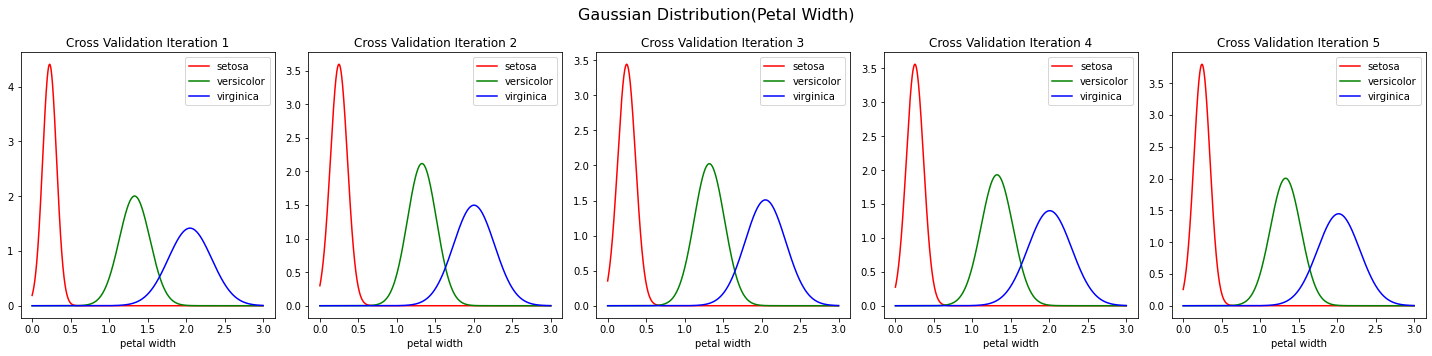

precision : 0.9562626262626261
recall : 0.9523232323232322


In [8]:
import numpy as np
precision = []
recall = []
fig, axes = plt.subplots(1,5,figsize=(20,5))
fig.suptitle("Gaussian Distribution(Petal Width)", fontsize=16)
#5-fold cross validation
for i in range(5):
    
    se_tp_n = 0 #setosa true positive
    ve_tp_n = 0 #versicolor true positive
    vi_tp_n = 0 #virginica true positive
    
    se_p_n = 0 #setosa positive
    ve_p_n = 0 #versicolor positive
    vi_p_n = 0 #virginica positive
    
    #(i+1)번째 fold는 evaluation에 사용하고 (i+1)번째 fold를 제외한 4개의 fold를 training에 사용
    idx_eval = idx[i*30: (i+1)*30]
    idx_data = idx[:i*30]+idx[(i+1)*30:]

    data = df.loc[idx_data]
    eval_data = df.loc[idx_eval]
    eval_class = eval_data['class']
    eval_prediction = []

    se_data=data[data['class'] =='Iris-setosa']
    ve_data=data[data['class']=='Iris-versicolor']
    vi_data=data[data['class']=='Iris-virginica']
    se_size = len(se_data)
    ve_size = len(ve_data)
    vi_size = len(vi_data)
    
    #prior
    se_prior = se_size/120
    ve_prior = ve_size/120
    vi_prior = vi_size/120
    
    #petal width gaussian distribution
    se_mean = se_data['petal width'].mean()
    se_std = se_data['petal width'].std()
    
    ve_mean = ve_data['petal width'].mean()
    ve_std = ve_data['petal width'].std()
    
    vi_mean = vi_data['petal width'].mean()
    vi_std = vi_data['petal width'].std()
    
    #petal width likelihood를 gaussian distribution으로 모델링한다.
    se_gaussian = np.zeros(31)
    ve_gaussian = np.zeros(31)
    vi_gaussian = np.zeros(31)

    pw = -0.1
    for j in range(31):
        pw += 0.1
        pw = round(pw,1)
        index = int(round((pw-0.0)/0.1,1))
        se_gaussian[index] = gaussian(pw, se_mean, se_std)
        ve_gaussian[index] = gaussian(pw, ve_mean, ve_std)
        vi_gaussian[index] = gaussian(pw, vi_mean, vi_std)
    
    se_pw_gaussian.append(se_gaussian)
    ve_pw_gaussian.append(ve_gaussian)
    vi_pw_gaussian.append(vi_gaussian)
        
    x = np.linspace(0,3,1000)
    axes[i].plot(x, gaussian(x, se_mean, se_std), label='setosa', color='red')
    axes[i].plot(x, gaussian(x, ve_mean, ve_std), label='versicolor', color='green')
    axes[i].plot(x, gaussian(x, vi_mean, vi_std), label='virginica', color='blue')
    axes[i].set_xlabel("petal width")
    axes[i].set_title("Cross Validation Iteration " + str(i+1))
    axes[i].legend()
    
    #petal width posterior probability
    se_posterior = np.zeros(31)
    ve_posterior = np.zeros(31)
    vi_posterior = np.zeros(31)
    
    for j in range(31) :
        evidence = se_gaussian[j] * se_prior + ve_gaussian[j] * ve_prior + vi_gaussian[j] * vi_prior
        if evidence == 0 :
            se_posterior[j] = 0
            ve_posterior[j] = 0
            vi_posterior[j] = 0
            continue
            
        se_posterior[j] = se_gaussian[j] * se_prior / evidence
        ve_posterior[j] = ve_gaussian[j] * ve_prior / evidence
        vi_posterior[j] = vi_gaussian[j] * vi_prior / evidence
  
    #(i+1)번째 fold에 대해 evaluation한다.
    for j in range(30):
        d = eval_data.iloc[j]
        pw = float(d['petal width'])
        pw_idx = int(round((pw-0.0)/0.1,1))
        
        max_prob = max(max(se_posterior[pw_idx],ve_posterior[pw_idx]),vi_posterior[pw_idx])
        if max_prob == se_posterior[pw_idx] : 
            eval_prediction.append('Iris-setosa')
            se_p_n += 1
            if d['class'] == 'Iris-setosa' : se_tp_n += 1
        elif max_prob == ve_posterior[pw_idx] : 
            eval_prediction.append('Iris-versicolor')
            ve_p_n += 1
            if d['class'] == 'Iris-versicolor' : ve_tp_n += 1
        elif max_prob == vi_posterior[pw_idx] : 
            eval_prediction.append('Iris-virginica')
            vi_p_n += 1
            if d['class'] == 'Iris-virginica' : vi_tp_n += 1
    
    if se_p_n == 0 :
        se_precision = 0
        se_recall = 0
    else : 
        se_precision = se_tp_n / se_p_n
        se_recall = se_tp_n / (50-se_size)
    
    if ve_p_n == 0 :
        ve_precision = 0
        ve_recall = 0
    else : 
        ve_precision = ve_tp_n / ve_p_n
        ve_recall = ve_tp_n / (50-ve_size)
        
    if vi_p_n == 0 :
        vi_precision = 0
        vi_recall = 0
    else : 
        vi_precision = vi_tp_n / vi_p_n
        vi_recall = vi_tp_n / (50-vi_size)

    precision.append((se_precision+ve_precision+vi_precision)/3)
    recall.append((se_recall+ve_recall+vi_recall)/3)

plt.tight_layout()
plt.show()
mean_precision = sum(precision)/5
mean_recall = sum(recall)/5

print("precision : " + str(mean_precision))
print("recall : " + str(mean_recall))


## 5.

In [9]:
import numpy as np
precision = []
recall = []

#5-fold cross validation
for i in range(5):
    
    se_tp_n = 0 #setosa true positive
    ve_tp_n = 0 #versicolor true positive
    vi_tp_n = 0 #virginica true positive
    
    se_p_n = 0 #setosa positive
    ve_p_n = 0 #versicolor positive
    vi_p_n = 0 #virginica positive
    
    #(i+1)번째 fold는 evaluation에 사용하고 (i+1)번째 fold를 제외한 4개의 fold를 training에 사용
    idx_eval = idx[i*30: (i+1)*30]
    idx_data = idx[:i*30]+idx[(i+1)*30:]

    data = df.loc[idx_data]
    eval_data = df.loc[idx_eval]
    eval_class = eval_data['class']
    eval_prediction = []

    se_data=data[data['class'] =='Iris-setosa']
    ve_data=data[data['class']=='Iris-versicolor']
    vi_data=data[data['class']=='Iris-virginica']
    se_size = len(se_data)
    ve_size = len(ve_data)
    vi_size = len(vi_data)
    
    #prior는 전체 120개 instance에 있는 각 class의 instance의 비율로 설정한다.
    se_prior = se_size/120
    ve_prior = ve_size/120
    vi_prior = vi_size/120
  
    #(i+1)번째 fold에 대해 evaluation한다.
    for j in range(30):
        d = eval_data.iloc[j]
        sl = float(d['sepal length'])
        sl_idx = int(round((sl-4.0)/0.1,1))
        sw = float(d['sepal width'])
        sw_idx = int(round((sw-2.0)/0.1,1))
        pl = float(d['petal length'])
        pl_idx = int(round((pl-1.0)/0.1,1))
        pw = float(d['petal width'])
        pw_idx = int(round((pw-0.0)/0.1,1))
        
        #evidence는 normalize 역할만 하고 대소 비교에는 영향을 주지 않으므로 생략한다.
        se_prob = se_sl_gaussian[i][sl_idx] * se_sw_gaussian[i][sw_idx] * se_pl_gaussian[i][pl_idx] * se_pw_gaussian[i][pw_idx] * se_prior
        ve_prob = ve_sl_gaussian[i][sl_idx] * ve_sw_gaussian[i][sw_idx] * ve_pl_gaussian[i][pl_idx] * ve_pw_gaussian[i][pw_idx] * ve_prior
        vi_prob = vi_sl_gaussian[i][sl_idx] * vi_sw_gaussian[i][sw_idx] * vi_pl_gaussian[i][pl_idx] * vi_pw_gaussian[i][pw_idx] * vi_prior
        
        max_prob = max(max(se_prob,ve_prob),vi_prob)
        if max_prob == se_prob : 
            eval_prediction.append('Iris-setosa')
            se_p_n += 1
            if d['class'] == 'Iris-setosa' : se_tp_n += 1
        elif max_prob == ve_prob: 
            eval_prediction.append('Iris-versicolor')
            ve_p_n += 1
            if d['class'] == 'Iris-versicolor' : ve_tp_n += 1
        elif max_prob == vi_prob : 
            eval_prediction.append('Iris-virginica')
            vi_p_n += 1
            if d['class'] == 'Iris-virginica' : vi_tp_n += 1
    
    if se_p_n == 0 :
        se_precision = 0
        se_recall = 0
    else : 
        se_precision = se_tp_n / se_p_n
        se_recall = se_tp_n / (50-se_size)
    
    if ve_p_n == 0 :
        ve_precision = 0
        ve_recall = 0
    else : 
        ve_precision = ve_tp_n / ve_p_n
        ve_recall = ve_tp_n / (50-ve_size)
        
    if vi_p_n == 0 :
        vi_precision = 0
        vi_recall = 0
    else : 
        vi_precision = vi_tp_n / vi_p_n
        vi_recall = vi_tp_n / (50-vi_size)

    precision.append((se_precision+ve_precision+vi_precision)/3)
    recall.append((se_recall+ve_recall+vi_recall)/3)

mean_precision = sum(precision)/5
mean_recall = sum(recall)/5

print("precision : " + str(mean_precision))
print("recall : " + str(mean_recall))


precision : 0.9609764309764308
recall : 0.9606565656565657
